In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import os
from torchvision.utils import make_grid
import os

# Hyperparameter initialization

In [2]:
latent_dim = 100
batch_size = 64
lr = 0.0002
num_epochs = 101
g_steps = 1
image_size = 28*28
image_channels = 1
hidden_dim_g = [512, 256,128]
hidden_dim_d = [128,256, 512]
dropout_rate = 0.3
#smooth labels
real_label_smooth = 0.9  # target for real images
fake_label_smooth = 0.1  # target for fake images
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Plotting helpers

In [3]:
def show_generated_images(generator, epoch=None, n=16):
    generator.eval()
    z = torch.randn(n, latent_dim).to(device)
    with torch.no_grad():
        fake_images = generator(z).view(n,1,28,28).cpu()
    grid = make_grid(fake_images, nrow=4, normalize=True)
    plt.figure(figsize=(4,4))
    plt.imshow(grid.permute(1,2,0))
    plt.axis("off")
    if epoch != None:
        plt.title(f"Epoch {epoch}")
    plt.show()
    generator.train()

In [4]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,),(0.5,))
])
mnist_train = datasets.MNIST(root='./training/data', train=True, download=True, transform=transform)
train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True, num_workers=2)

# Model architecture

In [5]:
class Generator(nn.Module):
    def __init__(self, latent_dim=latent_dim, hidden_dim_g=hidden_dim_g):
        super().__init__()
        layers = []
        in_dim = latent_dim
        for h_dim in hidden_dim_g:
            layers.append(nn.Linear(in_dim, h_dim))
            layers.append(nn.BatchNorm1d(h_dim))
            layers.append(nn.ReLU())
            in_dim = h_dim
        layers.append(nn.Linear(in_dim, 784))
        layers.append(nn.Tanh())
        self.model = nn.Sequential(*layers)
    def forward(self, z):
        return self.model(z)
'''class Discriminator(nn.Module):

Inputting and saving a long list of digits

    def __init__(self, hidden_dim_d=hidden_dim_d):
        super().__init__()
        layers = []
        in_dim = 784
            
        for hidden_dimension_d in hidden_dim_d[0:-1]:
            layers.append(nn.Linear(in_dim,hidden_dimension_d))
            layers.append(nn.BatchNorm1d(hidden_dimension_d))
            layers.append(nn.LeakyReLU(0.2))
            layers.append(nn.Dropout(0.3))
            in_dim = hidden_dimension_d
        layers.append(nn.Linear(in_dim, hidden_dim_d[-1]))
        layers.append(nn.LeakyReLU(0.2))
        layers.append(nn.Linear(hidden_dim_d[-1],1))
        layers.append(nn.Sigmoid())
        self.model = nn.Sequential(*layers)
    def forward(self, x):
        x = x.view(x.size(0), -1)
        return self.model(x)'''
class Discriminator(nn.Module):
    def __init__(self, hidden_dim_d=hidden_dim_d):
        super().__init__()
        layers = []
        in_dim = 784
        
        # First layer
        layers.append(nn.Linear(in_dim, hidden_dim_d[0]))
        layers.append(nn.LeakyReLU(0.2))
        layers.append(nn.Dropout(dropout_rate))
        in_dim = hidden_dim_d[0]
        
        # Middle layers
        for hidden_dimension_d in hidden_dim_d[1:-1]:
            layers.append(nn.Linear(in_dim, hidden_dimension_d))
            layers.append(nn.BatchNorm1d(hidden_dimension_d))
            layers.append(nn.LeakyReLU(0.2))
            layers.append(nn.Dropout(dropout_rate))
            in_dim = hidden_dimension_d
        
        # Last hidden layer
        layers.append(nn.Linear(in_dim, hidden_dim_d[-1]))
        layers.append(nn.LeakyReLU(0.2))
        
        # Output layer
        layers.append(nn.Linear(hidden_dim_d[-1], 1))
        # we will use BCEWithLogitsLoss
        
        self.model = nn.Sequential(*layers)
    
    def forward(self, x):
        x = x.view(x.size(0), -1)
        return self.model(x)

## Create generator and discriminator instances

In [6]:
generator = Generator()
discriminator = Discriminator()

# Training

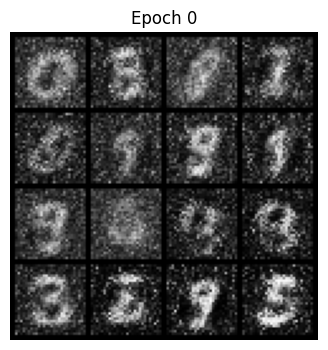

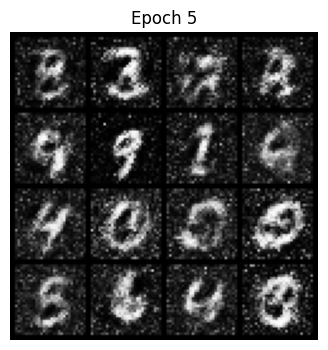

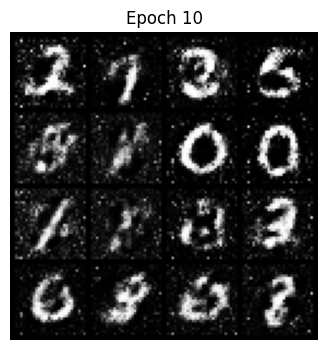

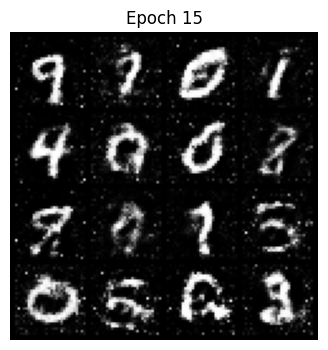

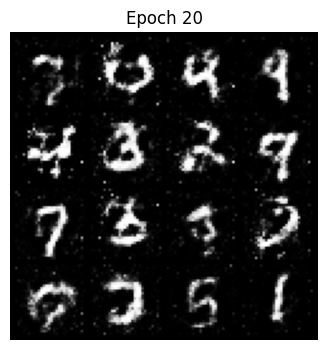

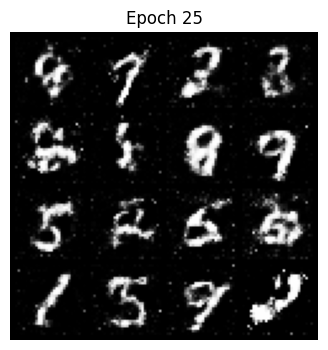

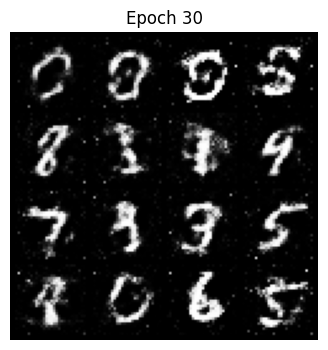

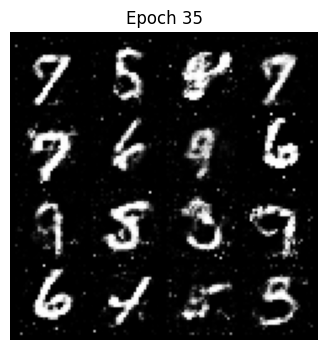

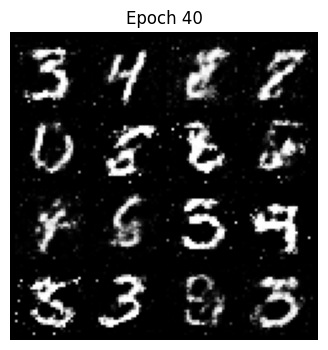

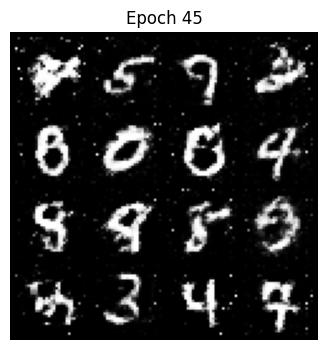

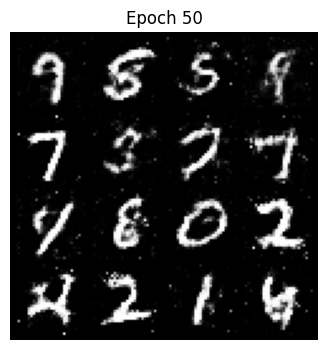

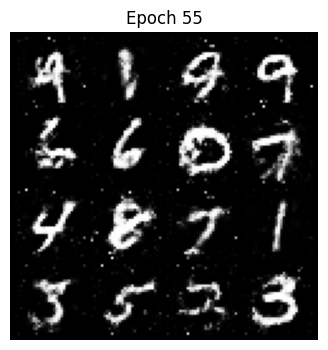

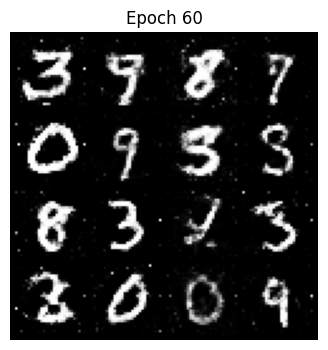

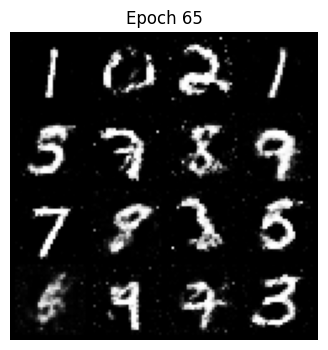

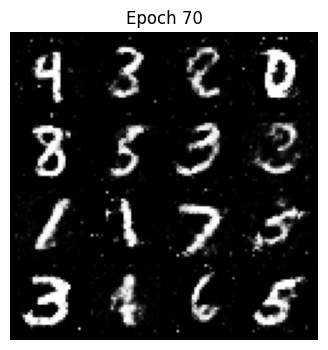

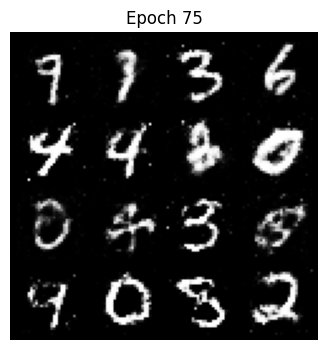

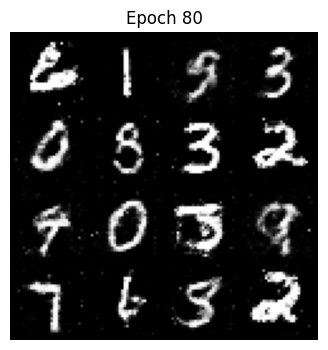

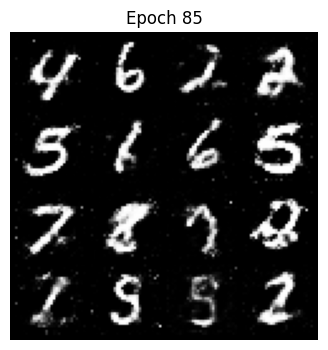

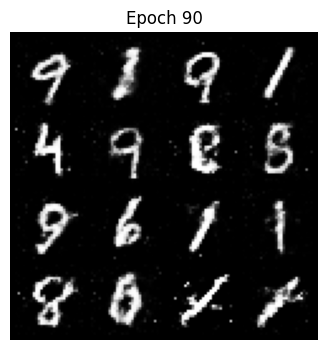

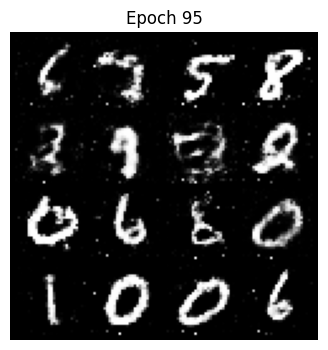

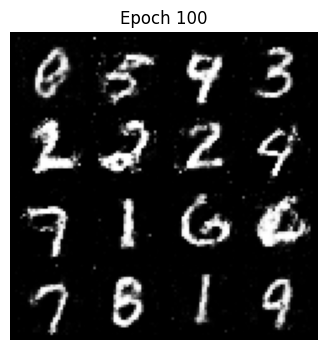

In [7]:
def train_discriminator(real_images):
    batch_size = real_images.size(0)
    real_images = real_images.view(batch_size, -1).to(device)
    real_labels = torch.full((batch_size, 1), real_label_smooth, device=device)
    fake_labels = torch.full((batch_size, 1), fake_label_smooth, device=device)
    
    z = torch.randn(batch_size, latent_dim).to(device)
    fake_images = generator(z)

    real_images += 0.1 * torch.randn_like(real_images)
    fake_images += 0.1 * torch.randn_like(fake_images)

    real_pred = discriminator(real_images)
    fake_pred = discriminator(fake_images.detach())

    real_loss = loss_fn(real_pred, real_labels)
    fake_loss = loss_fn(fake_pred, fake_labels)
    d_loss = real_loss + fake_loss

    discriminatorOptimizer.zero_grad()
    d_loss.backward()
    discriminatorOptimizer.step()

    return d_loss.item()

def train_generator(batch_size):
    z = torch.randn(batch_size, latent_dim).to(device)
    fake_images = generator(z)
    fake_pred = discriminator(fake_images)
    real_labels = torch.full((batch_size, 1), real_label_smooth, device=device)
    g_loss = loss_fn(fake_pred, real_labels)

    generatorOptimizer.zero_grad()
    g_loss.backward()
    generatorOptimizer.step()

    return g_loss.item()

generator.to(device)
discriminator.to(device)
loss_fn = nn.BCEWithLogitsLoss()

g_losses = []
d_losses = []

checkpoint_dir = "checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)

generatorOptimizer = optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
discriminatorOptimizer = optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))

generator.train()
discriminator.train()

for epoch in range(num_epochs):
    for real_images, _ in train_loader:
        real_images = real_images.to(device)

        d_loss = train_discriminator(real_images)
        d_losses.append(d_loss)

        for _ in range(g_steps):
            batch_size = real_images.size(0)
            g_loss = train_generator(batch_size)
            g_losses.append(g_loss)

    if epoch % 5 == 0:
        show_generated_images(generator, epoch)

    if epoch % 10 == 0:
        torch.save(generator.state_dict(), f"{checkpoint_dir}/generator_epoch_{epoch}.pt")
        torch.save(discriminator.state_dict(), f"{checkpoint_dir}/discriminator_epoch_{epoch}.pt")


## Plot loss after training

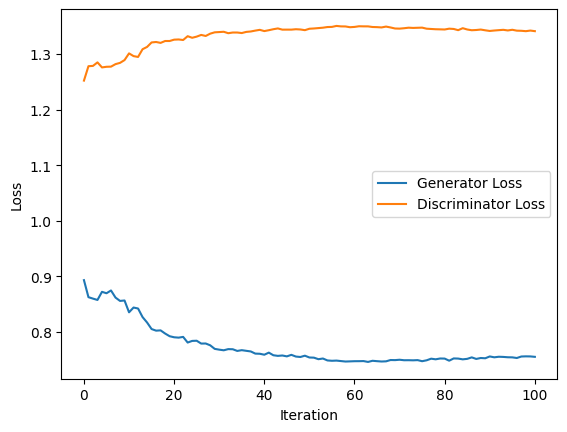

In [8]:
import math
g_aggragated = np.array(g_losses).reshape(num_epochs, -1).mean(axis=1)
d_aggragated = np.array(d_losses).reshape(num_epochs, -1).mean(axis=1)
plt.plot(g_aggragated, label="Generator Loss")
plt.plot(d_aggragated, label="Discriminator Loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()
plt.show()

## Load an existing generator

In [8]:
generator = Generator()
generator.load_state_dict(torch.load("trained models/model.pt"))
generator.to(device)

/tmp/ipykernel_18327/2472067196.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  generator.load_state_dict(torch.load("trained models/model.pt"))


Generator(
  (model): Sequential(
    (0): Linear(in_features=100, out_features=512, bias=True)
    (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=512, out_features=256, bias=True)
    (4): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Linear(in_features=256, out_features=128, bias=True)
    (7): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): Linear(in_features=128, out_features=784, bias=True)
    (10): Tanh()
  )
)

## Generate images

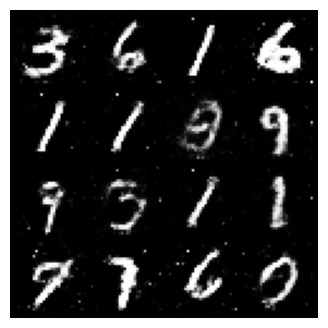

In [21]:
show_generated_images(generator)